In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

In [2]:
df_gold = pd.read_csv('GOLDSTEIN_WHOLE_ML_DATASET.csv')
df_ros = pd.read_csv('ROSEN_WHOLE_ML_DATASET.csv')

In [3]:
f_star = df_gold['val'].to_numpy()[-1]

In [4]:
fi = df_gold['val'].copy()
fi = fi - f_star
fii = fi.copy()
# delete first element from fi and last from fii
fi.drop(index=0, inplace=True)
fii.drop(index=(len(fii)-1), inplace=True)

In [5]:
fi = fi.to_numpy()
fii = fii.to_numpy()

In [6]:
convergence_gold = fi #/ fii

In [7]:
print(len(convergence_gold))

5366


(-1.0, 30.0)

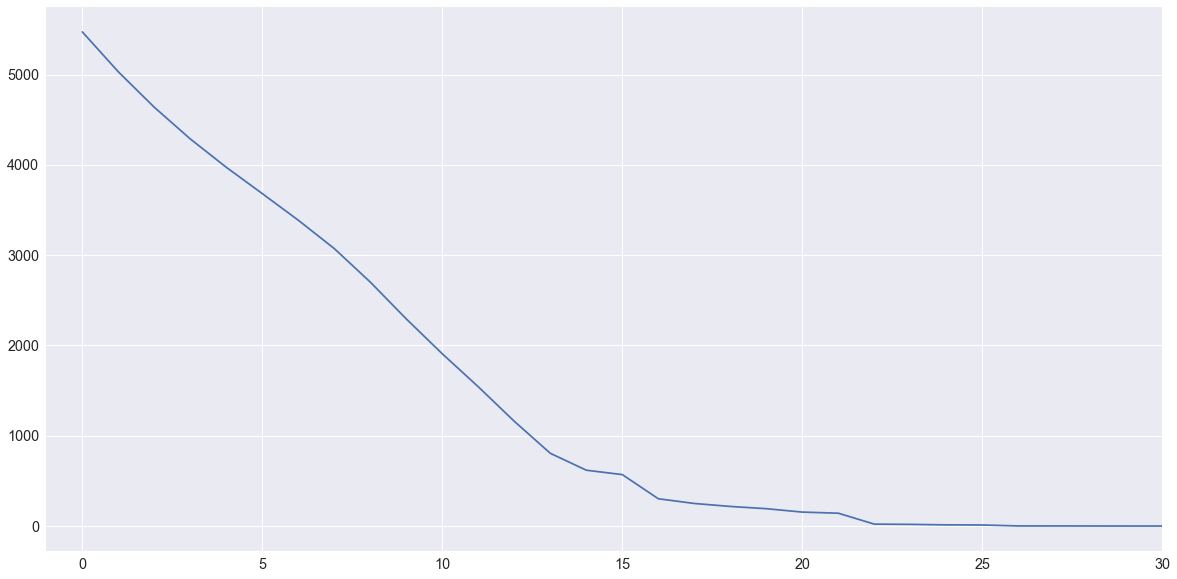

In [8]:
plt.plot([*range(len(convergence_gold))], convergence_gold)
#plt.ylim(-1, 10)
plt.xlim(-1, 30)

False


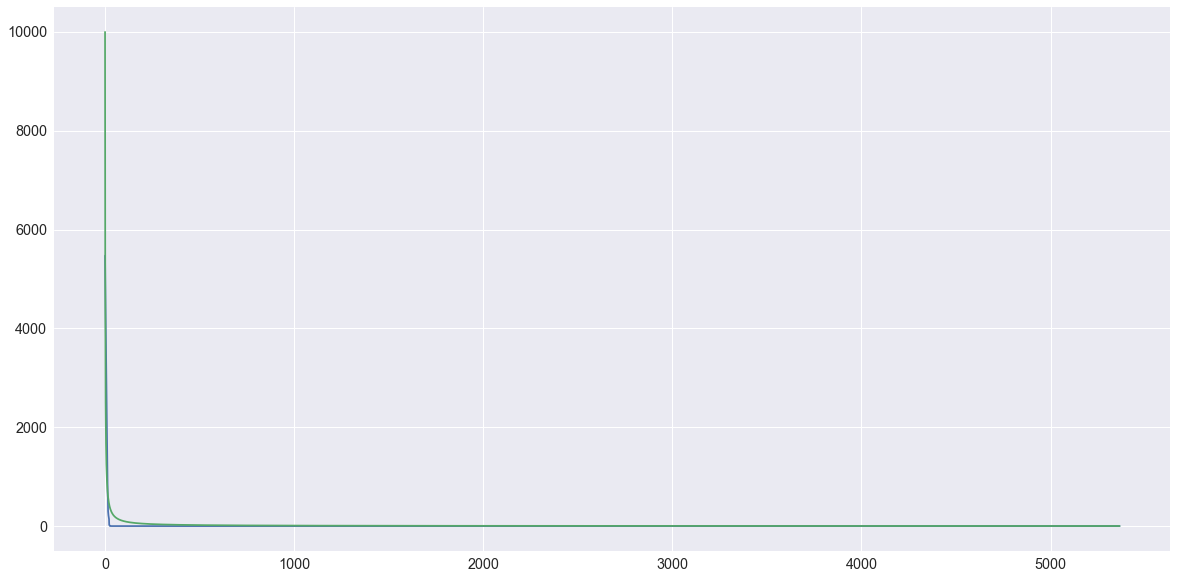

In [9]:
plt.plot([*range(len(convergence_gold))], convergence_gold)

hyp = [1e4*(1/(1+n)) for n in range(len(convergence_gold))]
print(all(convergence_gold < hyp))
plt.plot([*range(len(convergence_gold))], hyp)

In [10]:
xnorm = df_gold['xnorm'].to_numpy()

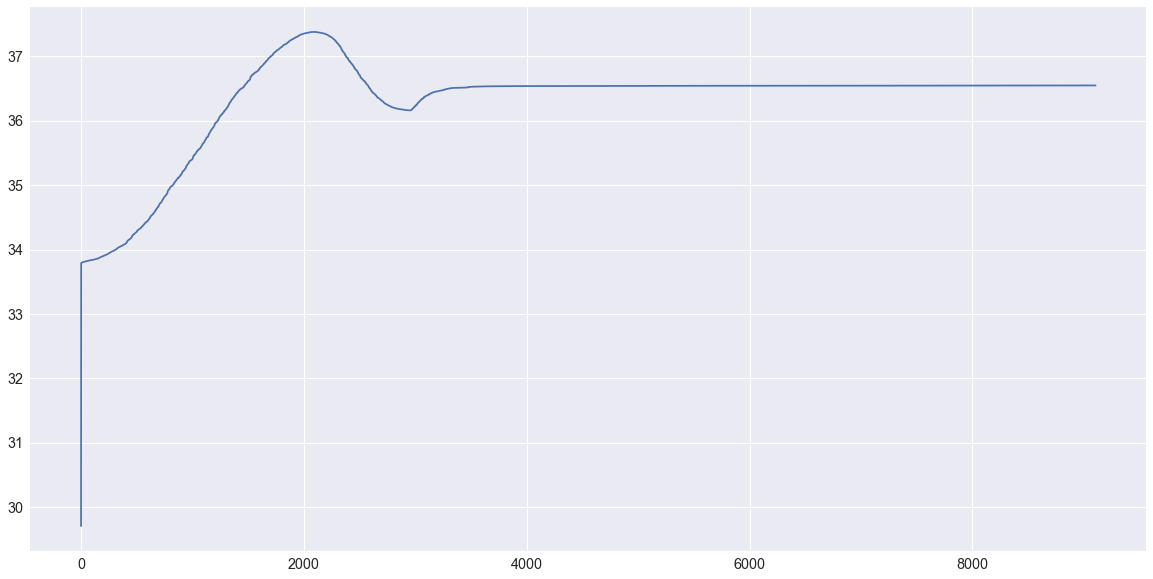

In [27]:
plt.plot([*range(len(xnorm))], xnorm)

# ROSEN

In [14]:
#f_star = df_ros['val'].to_numpy()[-1]

In [15]:
fi = df_ros['val'].copy()
fi = fi - f_star
fii = fi.copy()
# delete first element from fi and last from fii
fi.drop(index=0, inplace=True)
fii.drop(index=(len(fii)-1), inplace=True)

In [16]:
fi = fi.to_numpy()
fii = fii.to_numpy()

In [17]:
convergence_ros = fi #/ fii

In [18]:
print(len(convergence_ros))

9105


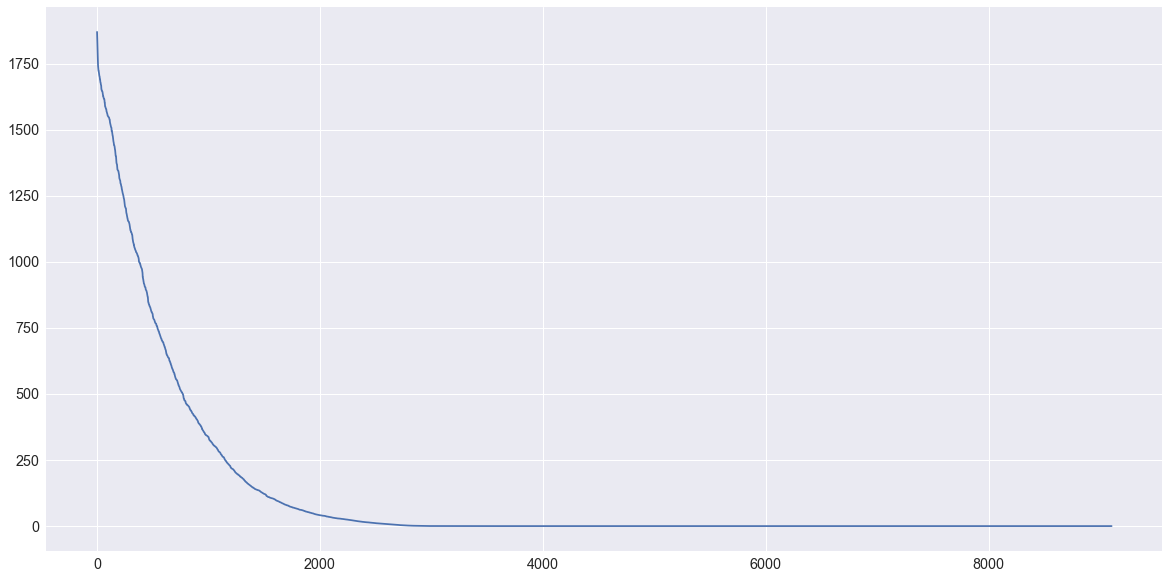

In [19]:
plt.plot([*range(len(convergence_ros))], convergence_ros)

In [20]:
xnorm = df_ros['xnorm'].to_numpy()

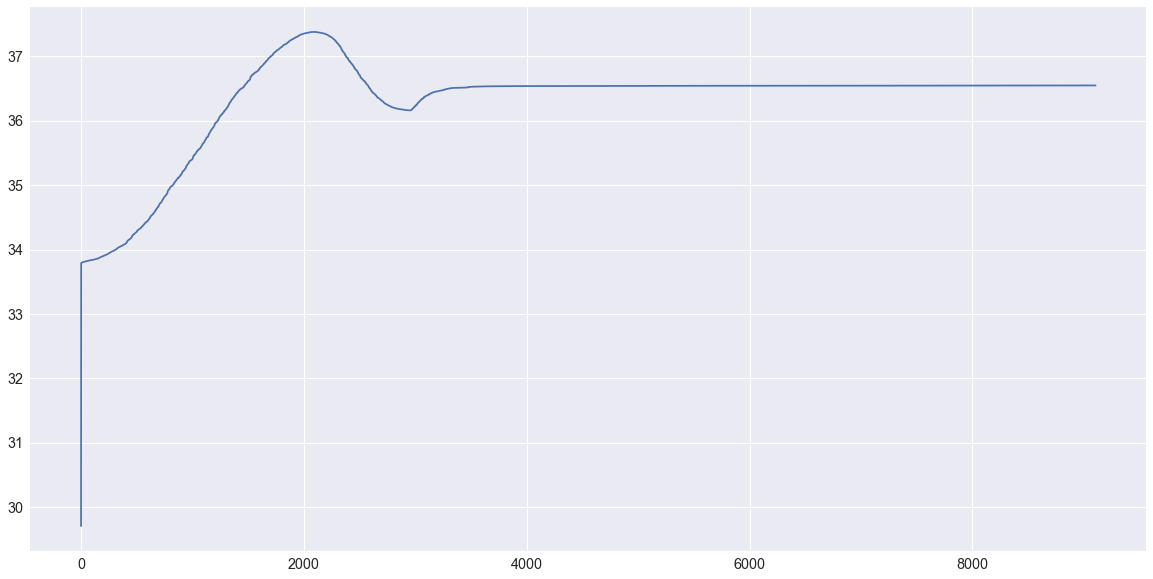

In [23]:
plt.plot([*range(len(xnorm))], xnorm)


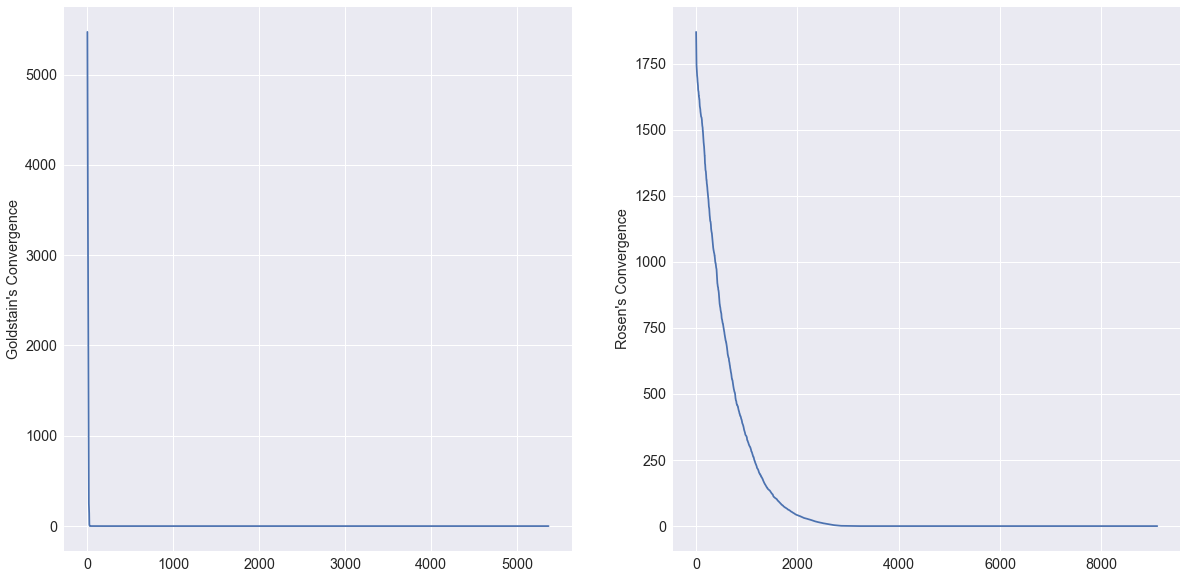

In [28]:
fig, (ax0, ax1) = plt.subplots(ncols=2)
ax0.set_ylabel("Goldstain's Convergence")
ax0.plot([*range(len(convergence_gold))], convergence_gold)
ax1.set_ylabel("Rosen's Convergence")
ax1.plot([*range(len(convergence_ros))], convergence_ros)

# Valore che scende

In [29]:
val_gold = df_gold['val']
val_ros = df_ros['val']

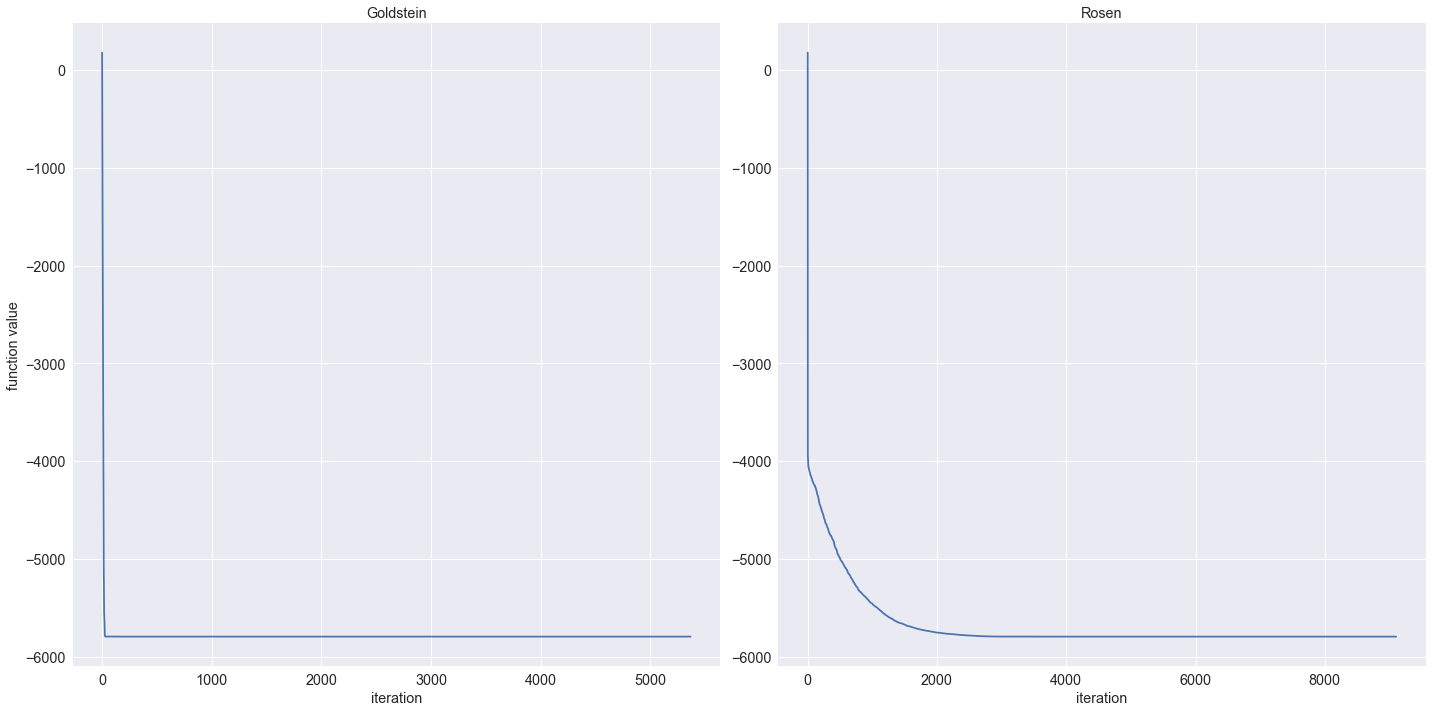

In [30]:
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=False)
val_gold.plot(ax=ax0)
val_ros.plot(ax=ax1)
ax0.set_ylabel("function value")
ax1.set_xlabel("iteration")
ax0.set_xlabel("iteration")
ax0.set_title("Goldstein")
ax1.set_title("Rosen")
plt.tight_layout()
plt.savefig("functionvalues.png")

In [31]:
goldsein_strano = pd.read_csv('GOLDSTEIN_STRANO.csv')

In [32]:
fstar_strano = goldsein_strano['val'].to_numpy()[-1]

<AxesSubplot:>

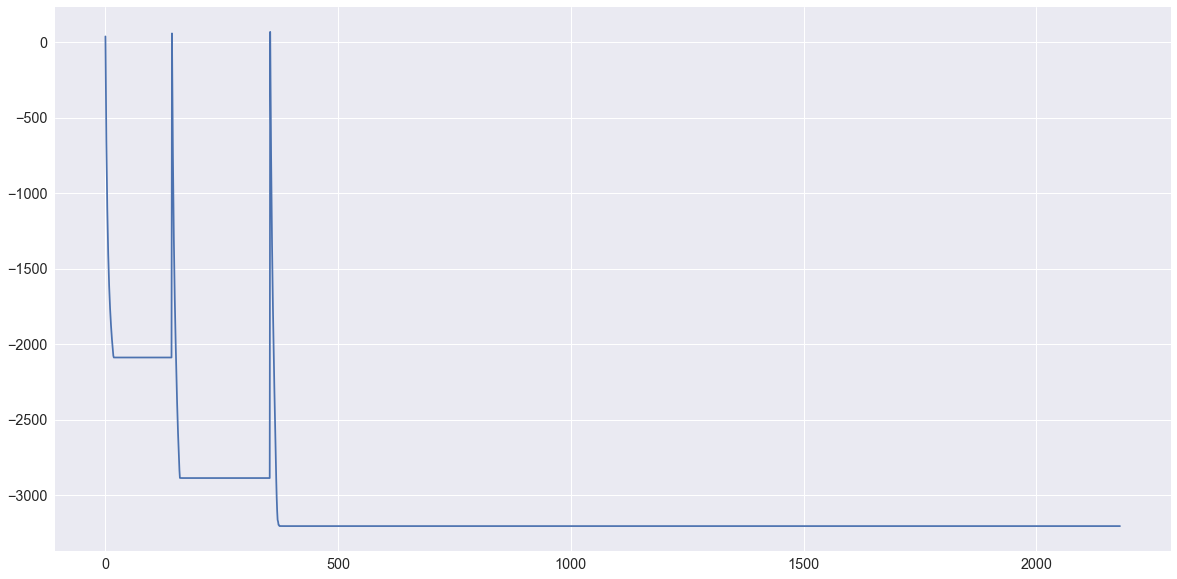

In [34]:
gold_val_stano = goldsein_strano['val']
gold_val_stano.plot()